<a href="https://colab.research.google.com/github/duckmanBR/desafios-dio-acw/blob/main/desafio_assistente_virtual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install gTTS SpeechRecognition pydub duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 19.0 MB/s eta 0:00:00


In [2]:
import time
import speech_recognition as sr
import requests
import random
import pprint
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from textwrap import wrap
from pydub import AudioSegment
from PIL import Image
from IPython.display import Audio, Javascript
from gtts import gTTS
from google.colab import output
from duckduckgo_search import DDGS
from base64 import b64decode

In [3]:
path_audio_files = '/content/audio'
os.makedirs(path_audio_files, exist_ok=True)
recognizer = sr.Recognizer()

# "gambiarra para fazer funcionar no COLAB pois ele não tem como acessar o microfone"
RECORD_JS = """
const sleep=time=>new Promise(resolve=>setTimeout(resolve, time));
const b2text=blob=>{
  const reader=new FileReader();
  reader.readAsDataURL(blob);
  return new Promise(resolve=>{
    reader.onloadend=()=>resolve(reader.result);
  });
};
var record=async function() {
  let stream=await navigator.mediaDevices.getUserMedia({audio:true});
  let recorder=new MediaRecorder(stream);
  let chunks=[];
  recorder.ondataavailable=e=>chunks.push(e.data);
  recorder.start();
  await sleep(6000); // Record for 10 seconds
  recorder.stop();
  await new Promise(resolve=>recorder.onstop=resolve);
  let blob=new Blob(chunks);
  return await b2text(blob);
};
"""

In [26]:
def falar(text_to_say):
    gtts = gTTS(text=text_to_say, lang="pt", slow=False, tld="com.br")
    filename = os.path.join(path_audio_files, f"{time.monotonic_ns()}.wav")
    gtts.save(filename)
    print(filename)
    while not os.path.exists(filename):
        time.sleep(1)
    return display(Audio(filename, autoplay=True))


# Como estamos no Colab, não é possível usar a biblioteca webbrowser, com isso temos que usar javascript (e o usuário precisa desbloquear popup manualmente)
def abrir_pagina_web(url):
    print("### Não se esqueça de desbloquear o pop-up do navegador! ###")
    display(Javascript('window.open("{url}");'.format(url=url)))


def gravar_audio():
    print("Gravando... Diga algo...", end=" ")
    display(Javascript(RECORD_JS))
    audio_data = output.eval_js("record()")
    audio_data = audio_data.split(",")[1]
    audio_bytes = b64decode(audio_data)

    # Convert to WAV format using pydub
    audio_segment = AudioSegment.from_file(io.BytesIO(audio_bytes), format="webm")

    return audio_segment


def transcrever_audio(audio_data):
    audio_wav_bytes = io.BytesIO()
    audio_data.export(audio_wav_bytes, format="wav")
    audio_wav_bytes.seek(0)  # Rewind the file pointer
    with sr.AudioFile(audio_wav_bytes) as source:
        recognizer.adjust_for_ambient_noise(source)
        audio_reconhecido = recognizer.record(source)
    try:
        texto = recognizer.recognize_google(audio_reconhecido, language="pt-BR")
        return texto
    except sr.UnknownValueError:
        return None
    except sr.RequestError:
        return None

def executa_comandos(texto):
    if "curiosidade" in texto or "quem foi" in texto:
        try:
          resposta_ddgs = DDGS().chat(texto, model="llama-3.3-70b")
        except NameError:
          return None
        return falar(resposta_ddgs)
    elif "previsão do tempo" in texto:
        try:
          resposta_ddgs = DDGS().text(f"{texto} site:climatempo.info", max_results=1, region="pt-BR")
        except NameError:
          return None
        return falar(resposta_ddgs[0]['body'])
    elif "youtube" in texto:
        texto = texto.replace("pesquisa no youtube sobre", "")
        try:
          resposta_ddgs = DDGS().videos(texto, license_videos="youtube", max_results=5, region="pt-BR", resolution="standart", safesearch="on")
        except NameError:
          return None
        num_images = len(resposta_ddgs)
        fig, ax = plt.subplots(1, num_images, figsize=(20, 5))
        fig.align_titles()
        for i, result in enumerate(resposta_ddgs):
            img_data = requests.get(result['images']['small']).content
            image = Image.open(io.BytesIO(img_data))
            ax[i].imshow(image)
            ax[i].axis("off")
            ax[i].set_title(f"{result['uploader']}\n"+"\n".join(wrap(result['title'], 20)))
        plt.show()
        return falar(f"Aqui estão 5 vídeos do youtube sobre {texto}")
    elif "pesquisa" in texto:
        texto = texto.replace("pesquisa", "")
        try:
          abrir_pagina_web(f"https://www.google.com/search?q={texto}")
        except NameError:
          return None
        return falar("abrindo outra aba para você visualizar os resultados")
    elif "desligar" in texto:
        falar("Desligando o sistema. Até logo.")
        raise KeyboardInterrupt




/content/audio/981543916388.wav


Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: chuva
Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: pesquisa no YouTube sobre chuva


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9928 (\N{THUNDER CLOUD AND RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


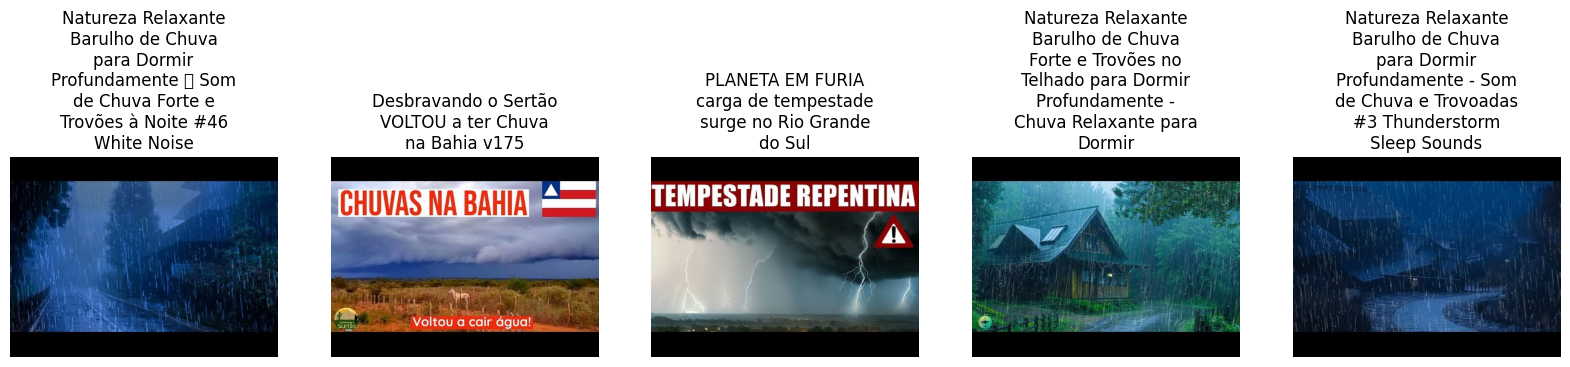

/content/audio/1005456988271.wav


Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: do Brasil
Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: curiosidades sobre o Brasil
/content/audio/1030100758431.wav


Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: previsão do tempo para o tanque
/content/audio/1064803974668.wav


Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: pesquisa sobre Tempe
### Não se esqueça de desbloquear o pop-up do navegador! ###


<IPython.core.display.Javascript object>

/content/audio/1108175309577.wav


Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Gravando... Diga algo...


<IPython.core.display.Javascript object>

Você disse: desligar
/content/audio/1129421709696.wav


KeyboardInterrupt: 

In [28]:
falar("Olá, como você está?  O que posso fazer para lhe ajudar hoje?")
while True:
    audio_data = gravar_audio()
    texto = transcrever_audio(audio_data)
    if texto:
      print(f"Você disse: {texto}")
      executa_comandos(texto.lower())


